# Contacts

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyIEEM.data.utils import to_pd_interval

## Settings

In [59]:
# GAM smoother
df = 5
degree = 2
# Age classes used
age_classes = ['[0, 10)','[10, 20)','[20, 30)','[30, 40)','[40, 50)','[50, 60)','[60, 70)','[70, 80)','[80, 120)']
age_classes_intervalindex = pd.IntervalIndex.from_tuples([(0,10),(10,20),(20,30),(30,40),(40,50),(50,60),(60,70),(70,80),(80,120)], closed='left')
# Load data
data_df = pd.read_csv('comesf_contacts.csv', dtype={'class_size': str})
# Make sure columns are in following order
data_df = data_df.set_index(['location', 'duration', 'type_day', 'vacation'])
data_df = data_df.sort_index()

## Functions

In [3]:
import statsmodels
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines
import statsmodels.formula.api as smf

def smooth_matrix(matrix, age_classes, age_classes_intervalindex, df, degree):
    """
    A function to GAM smooth contact matrices
    
    Input
    -----
    
    matrix: pd.Series
        Index: age_x, age_y. Name: predicted_contacts. Unsmoothed matrix.
        
    age_classes: list containing str
        String representation of the age groups
        
    age_classes_intervalindex: pd.Intervalindex
        Corresponding intervalindex
        
    df: int
        Number of B-splines for GAM fit
        
    degree: int
        Degree of B-splines for GAM fit    
    
    Output
    ------
    
    matrix: pd.Series
        Index: age_x, age_y. Name: predicted_contacts. Smoothed matrix.
    """
    
    # drop index
    matrix = matrix.reset_index()

    # replace categoral with midpoint of interval (in case data are not equidistant)
    for var in ['age_x', 'age_y']:
        for i,age_class in zip(range(len(age_classes)), age_classes):
            matrix.loc[matrix.index[matrix[var] == age_class], var] = age_classes_intervalindex[i].mid  
    
    matrix = matrix.astype(float)

    # save the midpoints
    midpoints_x = matrix['age_x'].unique() 
    midpoints_y = matrix['age_y'].unique() 

    # define dataframe with zeros
    names = ['age_x', 'age_y']
    iterables = [midpoints_x, midpoints_y]
    desired_df = pd.Series(0, index=pd.MultiIndex.from_product(iterables, names=names), name='desired_format')
    
    # merge smoothed data into desired format
    mat = matrix.groupby(by=['age_x','age_y']).last()
    mat = mat['predicted_contacts'].combine_first(desired_df)
    
    # unstack dataframe and interpolate the nan values linearily
    mat = mat.unstack(level=1).interpolate(method='linear', limit_area='inside')
    mat = mat.fillna(0)
    mat = mat.stack()
    mat = mat.rename('predicted_contacts')
    
    # recycle name matrix
    matrix = mat.reset_index()
    
    # now fit another GAM including the zeros
    x_spline = matrix[['age_x', 'age_y']]
    bs = BSplines(x_spline, df=[df,df], degree=[degree, degree])
    model = GLMGam.from_formula('predicted_contacts ~ age_x + age_y + age_x*age_y', data=matrix, smoother=bs,
                                family=sm.families.NegativeBinomial(), alpha=np.array([0.1, 0.1]), method='newton')

    # fit GAM model
    res = model.fit()
    
    # predict matrix of contacts
    smoothed_values = res.predict()
    
    # merge back into dataframe
    matrix['predicted_contacts'] = smoothed_values
    
    # set multiindex
    matrix = matrix.groupby(by=['age_x','age_y']).last()

    # re-introduce the age classes as index
    matrix.index = matrix.index.set_levels(age_classes, level=0)
    matrix.index = matrix.index.set_levels(age_classes, level=1)

    return matrix.squeeze()

In [79]:
def do_GEE(data, formula, age_classes, age_classes_intervalindex, df, degree):
    """
    A function to perform GEE on the raw contact data
    
    Input
    -----
    
    data: pd.DataFrame
       Columns: ID, age_x, age_y, reported number of contacts. (minimal)
       Optional variables: sex, household_size, class_size, highest_education, professional_situation, sector
    
    formula: str
        Regression formula. f.i. 'reported_contacts ~ sex + age_x + age_y + age_x*age_y'
        
    age_classes: list containing str
        String representation of the age groups
        
    age_classes_intervalindex: pd.Intervalindex
        Corresponding intervalindex
        
    df: int
        Number of B-splines for GAM fit
        
    degree: int
        Degree of B-splines for GAM fit
    
    Output
    ------
    
    data_GEE: pd.Dataframe
        Index: age_x, age_y. Contact matrix after GEE. Contains nan where no observation exists.
        
    n: int
        Number of participants
    """
    
    # extract number of reported contacts
    n = len(data['reported_contacts'].to_numpy().nonzero()[0])
    
    # GEE regression
    fam = sm.families.NegativeBinomial()
    ind = sm.cov_struct.Independence()
    mod = smf.gee(formula, "ID", data, cov_struct=ind, family=fam)
    res = mod.fit()

    # format data
    data = data.reset_index()
    data['predicted_contacts'] = res.predict()
    data = data.drop(columns=['ID'])
    data = data.groupby(by=['age_x', 'age_y']).last()
    
    # merge with a pre-made dataframe containing all entries (nan where no prediction exists)
    names = ['age_x', 'age_y']
    iterables = 2*[age_classes,]
    desired_df = pd.Series(index=pd.MultiIndex.from_product(iterables, names=names), name='desired_format', dtype=float)
    
    # data post GEE
    data_GEE = data['predicted_contacts'].combine_first(desired_df)

    return data_GEE, n

## Analysis

In [80]:
# manually set exceptions yielding seperation errors in the GEE
exceptions = [
    ('transport', '> 240 min', 'weekday', False),
    ('transport', '15-60 min', 'weekendday', True),
    ('transport', '15-60 min', 'weekendday', False),
]

# make a dataframe to save the results
locations = data_df.index.get_level_values('location').unique()
durations = data_df.index.get_level_values('duration').unique()
types_day = data_df.index.get_level_values('type_day').unique()
vacations = data_df.index.get_level_values('vacation').unique()
ages_x = ages_y = age_classes
iterables = [locations, durations, types_day, vacations, ages_x, ages_y]
names = ['location', 'duration', 'types_day', 'vacations', 'age_x', 'age_y']
results_GEE = pd.Series(index=pd.MultiIndex.from_product(iterables, names=names), name='predicted_contacts', dtype=float)

# Define formula dictionary
formula = {
    'home': 'reported_contacts ~ age_x + age_y + age_x*age_y + household_size',
    'school': 'reported_contacts ~ age_x + age_y + age_x*age_y + sex',
    'leisure_public': 'reported_contacts ~ age_x + age_y + age_x*age_y + sex + professional_situation',
    'leisure_private': 'reported_contacts ~ age_x + age_y + age_x*age_y + sex + household_size + professional_situation',
    'transport': 'reported_contacts ~ age_x + age_y + age_x*age_y + sex + professional_situation',
    'work_indoor': 'reported_contacts ~ age_x + age_y + age_x*age_y + sex + professional_situation',
    'work_leisure_outdoor': 'reported_contacts ~ age_x + age_y + age_x*age_y + sex + professional_situation',
    'SPC': 'reported_contacts ~ age_x + age_y + age_x*age_y + sex + professional_situation',
}

# loop over all possible contact matrices, fit GEE and smooth using GAM
for location in data_df.index.get_level_values('location').unique():
    if location != 'SPC':
        for duration in data_df.index.get_level_values('duration').unique():
            for type_day in data_df.index.get_level_values('type_day').unique():
                for vacation in data_df.index.get_level_values('vacation').unique():

                        # Extract data
                        data = data_df.loc[location, duration, type_day, vacation]

                        n = len(data['reported_contacts'].to_numpy().nonzero()[0])
                        print(location, duration, type_day, vacation, n)

                        if ((all(a == (location, duration, type_day, vacation) for a in exceptions)) | \
                                (len(data.to_numpy().nonzero()[0]) <= 2)):

                            names = ['age_x', 'age_y']
                            iterables = 2*[age_classes,]
                            data_GEE = pd.Series(0,index=pd.MultiIndex.from_product(iterables, names=names), name='predicted_contacts')
                            #data_smooth = data_GEE
                            n = 0
                        else:
                            # GEE
                            data_GEE, n = do_GEE(data, formula[location], age_classes, age_classes_intervalindex, df, degree)
                            #data_smooth = smooth_matrix(data_GEE, age_classes, age_classes_intervalindex, df, degree)

                        # save result
                        results_GEE.loc[location, duration, type_day, vacation, slice(None), slice(None),] = data_GEE.values    
                        #results_smooth.loc[location, duration, type_day, vacation, slice(None), slice(None)] = data_smooth.values    

                        # Extract matrix
                        mat = mat_smooth = data_GEE.values.reshape(2*[len(age_classes),])
                        #mat_smooth = data_smooth.values.reshape(2*[len(age_classes),])

                        # Visualise matrix smoothed vs. unsmoothed
                        titles=['unsmoothed', f'GAM smoothed ({df}, {degree})']
                        fig,axs=plt.subplots(nrows=1, ncols=2, sharey=True)
                        for i,m in enumerate([mat, mat_smooth]):
                            ax = axs[i]
                            ax = sns.heatmap(m, annot=True, fmt='.2f', ax=ax, square=True, cbar=False, annot_kws={"size":6})
                            ax.xaxis.tick_top() # x axis on top
                            ax.xaxis.set_label_position('top')
                            ax.set_xticklabels(age_classes, rotation = 30, size=8)
                            ax.set_yticklabels(age_classes, rotation = 30, size=8)
                            ax.set_title(f'{titles[i]}\navg. contacts: {np.mean(np.sum(m,axis=1)):.2f}', fontsize=10)

                            if i == 0:
                                ax.set(ylabel='participant age')

                        fig.suptitle(f'{location} on a {type_day} (n={n})\nduration: {duration}, vacation: {vacation}')
                        plt.tight_layout()
                        # check if the path exists and if not make it
                        #if not os.path.exists(f'figs/{location}/{type_day}/'):
                        #    os.makedirs(f'/figs/{location}/{type_day}/')

                        plt.savefig(f'figs/{location}/{type_day}/mat_{duration}_{vacation}.png')
                        plt.close()

home 15-60 min weekday False 593
home 15-60 min weekday True 499
home 15-60 min weekendday False 112
home 15-60 min weekendday True 213
home 5-15 min weekday False 445
home 5-15 min weekday True 300



KeyboardInterrupt



Error in callback <function flush_figures at 0x14e5f9446660> (for post_execute):



KeyboardInterrupt



## Total number of contacts

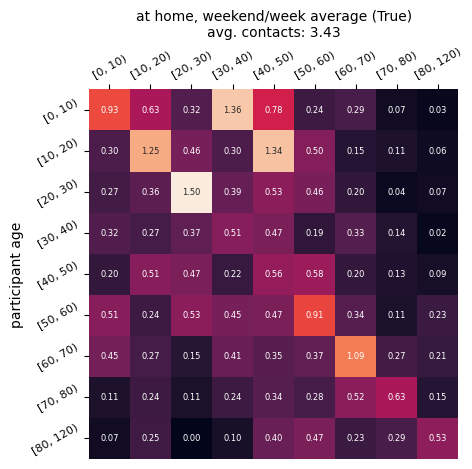

In [46]:
results = results_GEE
location = 'home'
vacation = True

# sum over durations
week = results.loc[location, slice(None), 'weekday', vacation].groupby(by=['age_x', 'age_y']).sum()#.values.reshape(2*[len(age_classes),])
weekend = results.loc[location, slice(None), 'weekendday', vacation].groupby(by=['age_x', 'age_y']).sum()#.values.reshape(2*[len(age_classes),])
m = (2/7*weekend + 5/7*week).values.reshape(2*[len(age_classes),])

# integrate durations
#trans = [2.5, 10, 37.5, 150, 240]
#m=0
#for i, duration in enumerate(results.index.get_level_values('duration').unique()):
#    m += trans[i]*results.loc[location, duration, daytype, vacation].values.reshape(2*[len(age_classes),])

# visualise result
fig,ax=plt.subplots()
ax = sns.heatmap(m, annot=True, fmt='.2f', ax=ax, square=True, cbar=False, annot_kws={"size":6})
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
ax.set_xticklabels(age_classes, rotation = 30, size=8)
ax.set_yticklabels(age_classes, rotation = 30, size=8)
ax.set_title(f'at {location}, weekend/week average ({vacation})\navg. contacts: {np.mean(np.sum(m,axis=1)):.2f}', fontsize=10)
ax.set(ylabel='participant age')
plt.show()
plt.close()